## Import Libraries and Run Query

In [28]:
import numpy as np
import pandas as pd
from scipy import stats
import os
import plotly.express as px
from matplotlib import pyplot as plt
from google_auth_oauthlib import flow
from plotly.subplots import make_subplots
import seaborn as sns
import plotly.graph_objects as go
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/geoff.parent/Desktop/coding_repo/credentials/mightyhive-data-science-poc-460f36144a00.json"

In [3]:
%%bigquery df   
SELECT  * FROM mightyhive-data-science-poc.001_namer_ds.010_consumer_sample

Downloading: 100%|██████████| 225405/225405 [00:02<00:00, 95662.89rows/s]


In [150]:
df.head()

CUSTNO    ZIP   ORDER_NO  PRODUCT_NO PRODUCT_CATEGORY_ID CHANNEL  \
0  10066154044  22801  129920453      983040                   P      ML   
1   9999917113  97520  129895678      983296                   T      ML   
2  10040744514  78582  129888573      983296                   T      ML   
3  10061657050  11752  129899497      983296                   T      ML   
4  10076287792  80226  129950736      983296                   T      ML   

  OFFER_ID ORDER_DATE   COST  REVENUE PAY_METHOD  QUANTITY  RETN_REVENUE  \
0   A08WNB 2008-01-18  49.99    99.95         PC         1           NaN   
1   A06EHB 2006-12-09  84.00   159.90         PC         2           NaN   
2   A06EHB 2006-09-27  42.00    79.95         PC         1           NaN   
3   A06LCB 2007-03-06  42.00    79.95         PC         1           NaN   
4   A09SPB 2009-02-24  42.00    39.95         MO         1           NaN   

   YEAR  MONTH MONTHYEAR  
0  2008      1   2008-01  
1  2006     12   2006-12  
2  2006      9   2006-09  
3  2007      3   2007-03  
4  2009      2   2009-02

## Pandas Profile

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title='Consumer Data')
profile

#### Summary Notes

- 7.3% missing cells (need to find out if these are disproportinatly affecting certain varaibles.)
- 372 duplicate rows (these need to be removed or is this because these is multiple items under an order that can be the same?)

#### Variable Notes

##### custno
- 44% distinct which means that 44% are return customers OR there are multiple line items for each order
- data has a negative skew. assuming a higher customer id is acquired later than a lower customer id this might say something about the growth of the business or the engagement of the customer later on
- it looks like customer ids might be scientific notation which might need to be cleaned later

##### Zip
- looks pretty evenly distributed around 200-300 for each zip
- assuming these are all in the us because of the 5 digit format, this makes up nearly half of the united states zip codes(41K)
- 56 values missing but this is a fraction of the data. could possibly see if there are other line items in an order that have the zip so we could fill them in? or if the customer id shows up more than once that would be use to fill this in.

##### order_no
- roughly half of all line items are unique which means that they above assumption is correct that there the granularity of this dataset is not on the order level. hence there can and are multiple line items for some orders
- Althought what this would also indicate is that most(60%) of orders are single item purchases
- the range for items in an order is 1-66
- theres are also 2 gaps in the order numbers although its to be determined if this is relevant 

##### product_ids
- assuming product ids are unique to a product and dont change over time, some products are much more popular than others. Overall though, with a distinct % of 2.3%, this means that orders are fairly diverse when it comes to the product ids that are contained within them.
- to quantify there are two product ids that make up 1% each of the total line items in dataset.
- There is a negative skew in this data. This could be relevant and posisbly coordinated with the rise in sales. (maybe later products are more popular than earlier products?
- its also possible that products ids are grouped by category but this is yet to be determined

##### product_category_id
- 18 product categories
- 4 categories (T,C,P,E) make up 60% of line times, with each around 14-15%
- all categories are denoted by a single letter str

##### channel
- 3 channels that are dentoed by 2 cahracter str
- one channel seems to be underperforming, only 4% (ML)
- other two channels WE & PH are closer together with 56% and 40% respectively

##### offer_id
- 6 character strings (0 character could denote web/app, characters 1 & 2 are the number of the campaign which looks like they are unique to the first letter in the string, the last 3 letters look like they could reference the channel but this will have to be pulled by looking at the last 3 letter in the sscript in grouping)
- This variable will most likely be split up in multiple variables possibly this could be kept too bc the number of campaign shouldnt have a significant impact by itself

##### order_date
- date value
- need to run stats on this. min,max and plot to see what timeframe is

##### cost
- assumption is this the cost to create the good and/or ship it
- there are no missing values but some values do have zero for cost so this could be a shipping costbc nothing costs 0 to make
- maximum is 3100 but the median is 24. positively skewed - most items dont cost too much

##### revenue
- in terms of profit percentage(using medians) 30/60 = 50%
- maximum is 5000 but median is 60. positively skewed
- the top 5 values (49.95, 39.95, 59.95, 29.95, 99.95) are roughly 50% of all purchased items(each with over 8% of the total). will have to graph this data without high outliers to find more patterns in this data. 
- 177 zero values but if we scroll down to returns there are 4500 which means that returns is an appended/ value that is updated on a record.

##### pay_method
- ? Unsure what this is but might have to make a dummy variable out of it

##### quantity
- No zero values and no missing values
- Postively Skewed
- 97% are 1
- outlier with 70 and the next value down is 18.

##### retrn_revenue
- as mentioned abvoe this is an append value to records (post and negative values are on each line)
- this is where most of missing values are in the dataset. missing data should be set to zero here



#### Additional Thoughts: 
- Should this be forecasted on the item, order or day(is there enought daily data to account for seasonality)?
- Do we want to forecast gross revenue, revenue(after returns), operating revenue(after cost & returns), returns




## Look at Time Series by Sum



In [5]:
###enhance dataframe with month and year
df_bydate = df.groupby(by='ORDER_DATE').sum()
df_bydate = df_bydate.reset_index()
df_bydate['ORDER_DATE'] = pd.to_datetime(df_bydate['ORDER_DATE'])
df_bydate['YEAR'] = df_bydate['ORDER_DATE'].dt.year
df_bydate['MONTH'] = df_bydate['ORDER_DATE'].dt.month
df_bydate['QUARTER'] = pd.PeriodIndex(df_bydate['ORDER_DATE'], freq='Q')
df_bydate.head()

ORDER_DATE        CUSTNO    ORDER_NO  PRODUCT_NO     COST  REVENUE  \
0 2005-01-01   70499163361   870074328     6836547   184.32   379.65   
1 2005-01-02  130893049032  1623027795    12715780   665.66  1429.35   
2 2005-01-03  251696487604  3130796194    24468757   607.27  1314.55   
3 2005-01-04  241488858976  3011526532    23449515  1253.13  2570.80   
4 2005-01-05  703740955527  8803843039    68201154  2359.62  5019.40   

   QUANTITY  RETN_REVENUE  YEAR  MONTH QUARTER  
0         7          0.00  2005      1  2005Q1  
1        13        339.90  2005      1  2005Q1  
2        29        299.90  2005      1  2005Q1  
3        24        269.95  2005      1  2005Q1  
4        70         59.95  2005      1  2005Q1

In [22]:
### Revenue
##fig = make_subplots(rows=2, cols=1)

fig = px.line(df_bydate, x='ORDER_DATE', y='REVENUE',title="Sum of Revenue by Day", width=1200, height=300)
fig.show()

Month Trend Varaition by Year


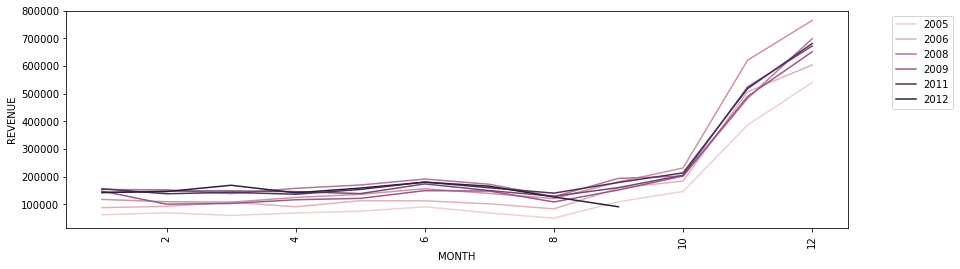

In [21]:
### monthly trend by year
df_bydate['MONTH'] = pd.DatetimeIndex(df_bydate['ORDER_DATE']).month
df_bydate['YEAR'] = pd.DatetimeIndex(df_bydate['ORDER_DATE']).year
df_monthyear = df_bydate.groupby(by=['MONTH','YEAR']).agg({'REVENUE':sum})
plt.figure(figsize=(14, 4))
sns.lineplot( x='MONTH', y='REVENUE', hue="YEAR",  data=df_monthyear)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
print('Month Trend Varaition by Year')
plt.show()

No handles with labels found to put in legend.


Month Trend Varaition by Year - CLEAN


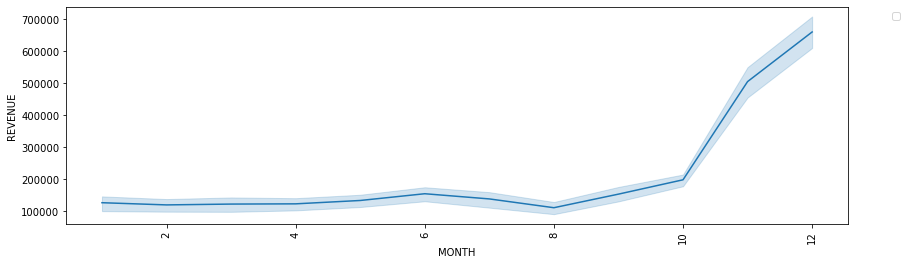

In [20]:
### same graph just cleaner
plt.figure(figsize=(14, 4))
sns.lineplot(x='MONTH', y='REVENUE', data=df_monthyear)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=90)
print('Month Trend Varaition by Year - CLEAN')
plt.show()

In [9]:
### returns
fig = px.line(df_bydate, x='ORDER_DATE', y='RETN_REVENUE',title="Sum of Returns by Day", width=1200, height=300)
fig.show()

In [10]:
### cost
fig = px.line(df_bydate, x='ORDER_DATE', y='COST',title="Sum of Cost by Day", width=1200, height=300)
fig.show()

### Time Series by Notes
##### Revenue by month trends
- not only is q4 higher than other years it varies more between years as well.
##### Revenue Sum by day
- cyclical, mostly popping up during the holiday season
- outlier in 2010 Q1
- 2006 Q4 was best year
##### Returns Sum by day
- returns peak in Q4
- outlier in 2011 Q1
- randomness the rest of the year and also random by year as well
##### Costs Sum by day
- no cyclical costs involved
- outlier in jan 2009 & 2010 q1
- matches the revenue patterns

In [11]:
df_bydate.head()

ORDER_DATE        CUSTNO    ORDER_NO  PRODUCT_NO     COST  REVENUE  \
0 2005-01-01   70499163361   870074328     6836547   184.32   379.65   
1 2005-01-02  130893049032  1623027795    12715780   665.66  1429.35   
2 2005-01-03  251696487604  3130796194    24468757   607.27  1314.55   
3 2005-01-04  241488858976  3011526532    23449515  1253.13  2570.80   
4 2005-01-05  703740955527  8803843039    68201154  2359.62  5019.40   

   QUANTITY  RETN_REVENUE  YEAR  MONTH QUARTER  
0         7          0.00  2005      1  2005Q1  
1        13        339.90  2005      1  2005Q1  
2        29        299.90  2005      1  2005Q1  
3        24        269.95  2005      1  2005Q1  
4        70         59.95  2005      1  2005Q1

## Category Groupings

In [61]:
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
df['YEAR'] = df['ORDER_DATE'].dt.year
df['MONTH'] = df['ORDER_DATE'].dt.month
df['MONTHYEAR'] = df['ORDER_DATE'].dt.to_period('m')
df_groupchannels = df.groupby(['MONTHYEAR', 'CHANNEL','PRODUCT_CATEGORY_ID','OFFER_ID','PAY_METHOD']).agg({'QUANTITY':sum,'REVENUE': sum,'RETN_REVENUE':sum,'COST':sum}).reset_index()

In [62]:
df_groupchannels['PROFIT'] = df_groupchannels['REVENUE']-df_groupchannels['RETN_REVENUE']-df_groupchannels['COST']
df_groupchannels.head()

MONTHYEAR CHANNEL PRODUCT_CATEGORY_ID OFFER_ID PAY_METHOD  QUANTITY  \
0   2005-01      ML                   B   A05WNB         PC         2   
1   2005-01      ML                   B   A05WNB         VI         1   
2   2005-01      ML                   C   A04GFB         PC         1   
3   2005-01      ML                   C   A05LWB         AX         2   
4   2005-01      ML                   C   A05WNB         AX         1   

   REVENUE  RETN_REVENUE    COST  PROFIT  
0   299.90          0.00   97.40  202.50  
1   129.95          0.00   58.25   71.70  
2    19.95          0.00    8.90   11.05  
3   539.90        469.95  235.00 -165.05  
4    64.95          0.00   24.50   40.45

In [63]:
categorystats = df_groupchannels.groupby(['PRODUCT_CATEGORY_ID']).agg({'QUANTITY':sum,'MONTHYEAR': [min, max],'REVENUE': sum,'RETN_REVENUE':sum,'COST':sum,'PROFIT':sum})
categorystats['profit_percent'] = categorystats[('PROFIT','sum')] / categorystats[('REVENUE','sum')]
categorystats['Returns_percent'] = categorystats[('RETN_REVENUE','sum')] / categorystats[('REVENUE','sum')]
categorystats.sort_values(by=[('REVENUE','sum')], ascending=False)

QUANTITY MONTHYEAR              REVENUE RETN_REVENUE  \
                         sum       min      max         sum          sum   
PRODUCT_CATEGORY_ID                                                        
E                      32344   2005-01  2012-09  3205446.30    215616.07   
P                      33602   2005-01  2012-09  2530905.85    155045.32   
T                      35203   2005-01  2012-09  2374709.94     76529.06   
C                      34717   2005-01  2012-09  2328616.46    207384.65   
H                      19860   2005-01  2012-09  2149258.53    167899.06   
F                      20145   2005-01  2012-09  1603039.15     68877.30   
B                      13997   2005-01  2012-09  1109597.79     66132.00   
X                       8886   2005-01  2012-09   927704.79     63559.52   
K                      10342   2005-01  2012-09   696100.05     30619.64   
L                       7024   2005-01  2012-09   642358.51     37987.50   
A                       7415   2005-01  2012-09   480677.45     29158.45   
O                       2325   2005-01  2012-09   345987.44     26034.54   
S                       4291   2005-01  2012-09   253329.16      4843.45   
J                       1852   2005-02  2012-09   112955.40      7102.25   
M                        732   2006-03  2012-09    89928.50      5072.80   
D                        714   2005-01  2012-09    79901.35      1469.40   
G                        237   2005-01  2012-08    34108.15      2304.35   
I                         14   2005-02  2012-09    18141.35         0.00   

                           COST      PROFIT profit_percent Returns_percent  
                            sum         sum                                 
PRODUCT_CATEGORY_ID                                                         
E                    1709048.64  1280781.59       0.399564        0.067266  
P                    1154699.32  1221161.21       0.482500        0.061261  
T                    1175792.93  1122387.95       0.472642        0.032227  
C                     967383.12  1153848.69       0.495508        0.089059  
H                    1035504.34   945855.13       0.440084        0.078120  
F                     702299.22   831862.63       0.518928        0.042967  
B                     453034.75   590431.04       0.532113        0.059600  
X                     375097.16   489048.11       0.527159        0.068513  
K                     353253.64   312226.77       0.448537        0.043987  
L                     237537.38   366833.63       0.571073        0.059138  
A                     203145.04   248373.96       0.516716        0.060661  
O                     171654.56   148298.34       0.428623        0.075247  
S                     113959.15   134526.56       0.531035        0.019119  
J                      46708.14    59145.01       0.523614        0.062877  
M                      39849.67    45006.03       0.500465        0.056409  
D                      34228.81    44203.14       0.553221        0.018390  
G                      17721.62    14082.18       0.412868        0.067560  
I                      11851.00     6290.35       0.346741        0.000000

In [64]:
channelstats = df_groupchannels.groupby(['CHANNEL']).agg({'QUANTITY':sum,'MONTHYEAR': [min, max],'REVENUE': sum,'RETN_REVENUE':sum,'COST':sum,'PROFIT':sum})
channelstats['profit_percent'] = channelstats[('PROFIT','sum')] / channelstats[('REVENUE','sum')]
channelstats['returns_percent'] = channelstats[('RETN_REVENUE','sum')] / channelstats[('REVENUE','sum')]
channelstats.sort_values(by=[('REVENUE','sum')], ascending=False)

QUANTITY MONTHYEAR                REVENUE RETN_REVENUE        COST  \
             sum       min      max           sum          sum         sum   
CHANNEL                                                                      
WE        126646   2005-01  2012-09  1.023357e+07    598208.16  4799371.36   
PH         98400   2005-01  2012-09  8.072792e+06    535164.35  3699200.80   
ML          8654   2005-01  2012-09  6.764019e+05     32262.85   304196.33   

             PROFIT profit_percent returns_percent  
                sum                                 
CHANNEL                                             
WE       4835992.32       0.472562        0.058455  
PH       3838427.24       0.475477        0.066292  
ML        339942.76       0.502575        0.047698

In [65]:
paymentstats = df_groupchannels.groupby(['PAY_METHOD']).agg({'QUANTITY':sum,'MONTHYEAR': [min, max],'REVENUE': sum,'RETN_REVENUE':sum,'COST':sum,'PROFIT':sum})
paymentstats['profit_percent'] = paymentstats[('PROFIT','sum')] / paymentstats[('REVENUE','sum')]
paymentstats['returns_percent'] = paymentstats[('RETN_REVENUE','sum')] / paymentstats[('REVENUE','sum')]
paymentstats.sort_values(by=[('REVENUE','sum')], ascending=False)

QUANTITY MONTHYEAR                REVENUE RETN_REVENUE        COST  \
                sum       min      max           sum          sum         sum   
PAY_METHOD                                                                      
VI           105340   2005-01  2012-09  8.368961e+06    522246.28  3858369.30   
MC            60645   2005-01  2012-09  4.855719e+06    305019.49  2250638.96   
AX            43575   2005-01  2012-09  3.751902e+06    222658.98  1755735.94   
DI            12086   2005-01  2012-09  9.675459e+05     69893.25   447490.63   
PC             7173   2005-01  2012-09  5.481573e+05     25357.75   245989.11   
PY             2465   2011-10  2012-09  1.923549e+05      9435.60    88509.01   
OA              748   2005-01  2012-09  1.108561e+05      5163.30    60102.82   
PX              556   2005-01  2012-09  7.088636e+04      1356.26    34648.36   
AZ              518   2011-04  2012-09  6.176610e+04         0.00    35561.58   
MO              413   2005-03  2012-09  3.524045e+04      3439.75    16219.67   
BM              110   2011-10  2012-09  1.262650e+04       879.80     6299.03   
MX               35   2005-03  2011-08  3.792300e+03       119.95     1699.10   
DC               25   2005-01  2008-11  1.844750e+03        64.95      989.93   
XX                5   2005-12  2007-08  5.647500e+02         0.00      284.56   
CA                3   2008-06  2011-04  4.198500e+02         0.00      182.25   
CC                3   2008-07  2008-07  1.298500e+02         0.00       48.24   

                PROFIT profit_percent returns_percent  
                   sum                                 
PAY_METHOD                                             
VI          3988345.02       0.476564        0.062403  
MC          2300060.40       0.473681        0.062817  
AX          1773506.74       0.472695        0.059346  
DI           450162.07       0.465262        0.072238  
PC           276810.42       0.504984        0.046260  
PY            94410.24       0.490813        0.049053  
OA            45589.95       0.411254        0.046577  
PX            34881.74       0.492080        0.019133  
AZ            26204.52       0.424254        0.000000  
MO            15581.03       0.442135        0.097608  
BM             5447.67       0.431447        0.069679  
MX             1973.25       0.520331        0.031630  
DC              789.87       0.428172        0.035208  
XX              280.19       0.496131        0.000000  
CA              237.60       0.565916        0.000000  
CC               81.61       0.628494        0.000000

### Category Notes
##### product_category
- all categories except for j,m,i have a max and min equal to the dataset
- revenue and profitability do not always match up; some categories are ranked higher in revenue but lower in profitability
- assuming cost is an attribute of a product and is therefore an attribute of PRODUCT_CATEGORY it is important to note that different categories have different profit percentages 

## Model


In [114]:
modeldf = df.groupby(by=['ORDER_DATE']).agg({'REVENUE':sum,'QUANTITY':sum, 'CUSTNO':pd.Series.nunique })
modeldf = modeldf.reset_index()
modeldf['NOV'] = np.where(modeldf['ORDER_DATE'].dt.month == 11, 1, 0)
modeldf['DEC'] = np.where(modeldf['ORDER_DATE'].dt.month == 12, 1, 0)
channeldummies = df.groupby(by=['ORDER_DATE','CHANNEL']).agg({'REVENUE':sum,'QUANTITY':sum, 'CUSTNO':pd.Series.nunique })
channeldummies = channeldummies.reset_index()
tempdf = channeldummies[['ORDER_DATE','CHANNEL','CUSTNO']]

In [115]:
temp_pivtodf = tempdf.pivot(index='ORDER_DATE', columns='CHANNEL', values='CUSTNO')
temp_pivtodf = temp_pivtodf.fillna(0)
temp_pivtodf.head()
temp_pivtodf = temp_pivtodf.reset_index()
temp_pivtodf.head()

CHANNEL ORDER_DATE   ML    PH    WE
0       2005-01-01  0.0   0.0   4.0
1       2005-01-02  0.0   3.0  10.0
2       2005-01-03  0.0   9.0   8.0
3       2005-01-04  0.0   7.0  10.0
4       2005-01-05  0.0  16.0  16.0

In [116]:
modeldf = modeldf.join(temp_pivtodf.set_index('ORDER_DATE'), on='ORDER_DATE')

In [117]:
finalmodeldf = modeldf.drop(['ORDER_DATE','CUSTNO'], axis = 1)
finalmodeldf.head()

REVENUE  QUANTITY  NOV  DEC   ML    PH    WE
0   379.65         7    0    0  0.0   0.0   4.0
1  1429.35        13    0    0  0.0   3.0  10.0
2  1314.55        29    0    0  0.0   9.0   8.0
3  2570.80        24    0    0  0.0   7.0  10.0
4  5019.40        70    0    0  0.0  16.0  16.0

In [118]:
finalmodeldf.columns

Index(['REVENUE', 'QUANTITY', 'NOV', 'DEC', 'ML', 'PH', 'WE'], dtype='object')

In [119]:
y = finalmodeldf['REVENUE']
x = finalmodeldf[['QUANTITY', 'NOV', 'DEC', 'ML', 'PH', 'WE']]

In [121]:
import statsmodels.api as sm
x = sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                REVENUE   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.327e+04
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:53:01   Log-Likelihood:                -24285.
No. Observations:                2815   AIC:                         4.858e+04
Df Residuals:                    2808   BIC:                         4.863e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        584.0379     37.685     15.498      0.000     510.144     657.932
QUANTITY      65.1738      1.951     33.401      0.000      61.348      69.000
NOV          308.9028    116.541      2.651      0.008      80.389     537.417
DEC         -155.6421    134.799     -1.155      0.248    -419.958     108.674
ML            12.1305      9.731      1.247      0.213      -6.949      31.210
PH            19.5728      4.383      4.466      0.000      10.979      28.166
WE            12.2800      3.968      3.094      0.002       4.499      20.061
==============================================================================
Omnibus:                     3322.246   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1395832.307
Skew:                           5.609   Prob(JB):                         0.00
Kurtosis:                     111.511   Cond. No.                         807.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [124]:
modeldf['quarterfour'] = np.where(modeldf['ORDER_DATE'].dt.month >= 10, 1, 0)
secondmodeldf = modeldf.drop(['ORDER_DATE','CUSTNO','NOV','DEC'], axis = 1)
secondmodeldf.head()


REVENUE  QUANTITY   ML    PH    WE  quarterfour
0   379.65         7  0.0   0.0   4.0            0
1  1429.35        13  0.0   3.0  10.0            0
2  1314.55        29  0.0   9.0   8.0            0
3  2570.80        24  0.0   7.0  10.0            0
4  5019.40        70  0.0  16.0  16.0            0

In [127]:
y = secondmodeldf['REVENUE']
x = secondmodeldf[['QUANTITY', 'quarterfour', 'ML', 'PH', 'WE']]

In [128]:
import statsmodels.api as sm
x = sm.add_constant(x)
results = sm.OLS(y,x).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                REVENUE   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 1.587e+04
Date:                Mon, 19 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:57:55   Log-Likelihood:                -24290.
No. Observations:                2815   AIC:                         4.859e+04
Df Residuals:                    2809   BIC:                         4.863e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         581.4029     37.050     15.692      0.000     508.755     654.051
QUANTITY       65.1511      1.953     33.360      0.000      61.322      68.980
quarterfour   104.9160     76.566      1.370      0.171     -45.215     255.047
ML             15.5521      9.655      1.611      0.107      -3.380      34.484
PH             21.1816      4.361      4.857      0.000      12.630      29.734
WE             10.5223      3.921      2.683      0.007       2.833      18.212
==============================================================================
Omnibus:                     3276.657   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1307598.766
Skew:                           5.480   Prob(JB):                         0.00
Kurtosis:                     108.015   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

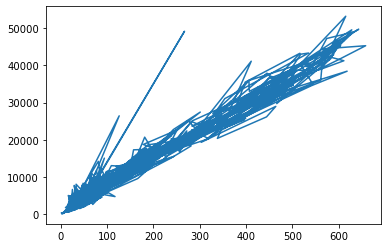

In [130]:
plt.plot(secondmodeldf['QUANTITY'],secondmodeldf['REVENUE'])

In [137]:
cust_df = df.groupby(df['CUSTNO']).agg({'QUANTITY':sum,'MONTHYEAR': [min, max],'REVENUE': sum, 'ORDER_NO':pd.Series.nunique})
cust_df = cust_df.reset_index()
cust_df.head()

CUSTNO QUANTITY MONTHYEAR          REVENUE ORDER_NO
                   sum       min      max     sum  nunique
0  9991187507        1   2007-10  2007-10   99.95        1
1  9991195310        2   2005-11  2007-12  119.90        2
2  9991202430        6   2009-11  2012-04  402.70        2
3  9991204402        2   2009-06  2009-06  147.90        1
4  9991215425        3   2005-11  2006-05  274.85        3

In [141]:
cust_df[('ORDER_NO','nunique')].mean()

1.374162669844099

<AxesSubplot:>

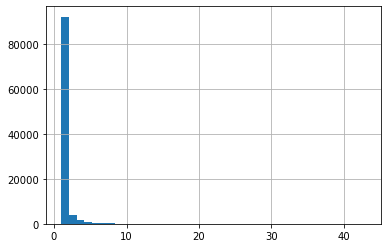

In [144]:
cust_df[('ORDER_NO','nunique')].hist(bins=40)

array([[<AxesSubplot:title={'center':'nunique'}>]], dtype=object)

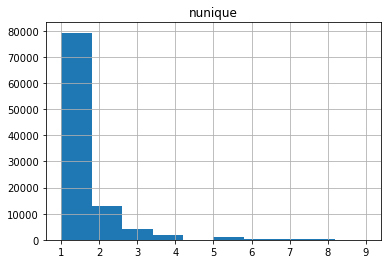

In [149]:
cust_df[cust_df[('ORDER_NO','nunique')] < 10]['ORDER_NO'].hist()